# Assignment 4:  Question duplicates

Welcome to the fourth assignment of course 3. In this assignment you will explore Siamese networks applied to natural language processing. You will further explore the fundamentals of Trax and you will be able to implement a more complicated structure using it. By completing this assignment, you will learn how to implement models with different architectures. 

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/sequence-models-in-nlp/supplement/6ThZO/how-to-refresh-your-workspace).

## Table of Contents

- [Overview](#0)
- [1 - Importing the Data](#1)
    - [1.1 - Loading in the Data](#1-1)
    - [1.2 - Converting a Question to a Tensor](#1-2)
    - [1.3 - Understanding the Iterator](#1-3)
        - [Exercise 1 - data_generator (UNQ_C1)](#ex-1)
- [2 - Defining the Siamese Model](#2)
    - [2.1 - Understanding Siamese Network](#2-1)
        - [Exercise 2 - Siamese (UNQ_C2)](#ex-2)
    - [2.2 - Hard Negative Mining](#2-2)
        - [Exercise 3 - TripletLossFn (UNQ_C3)](#ex-3)
- [3 - Training](#3)
    - [3.1 - Training the Model](#3-1)
        - [Exercise 4 - train_model (UNQ_C4)](#ex-4)
- [4 - Evaluation](#4)
    - [4.1 - Evaluating your Siamese Network](#4-1)
    - [4.2 - Classify](#4-2)
        - [Exercise 5 - classify (UNQ_C5)](#ex-5)
- [5 -Testing with your Own Questions](#5)
    - [Exercise 6 - predict (UNQ_C6)](#ex-6)
- [On Siamese Networks](#6)

<a name='0'></a>
## Overview
In this assignment, concretely you will: 

- Learn about Siamese networks
- Understand how the triplet loss works
- Understand how to evaluate accuracy
- Use cosine similarity between the model's outputted vectors
- Use the data generator to get batches of questions
- Predict using your own model

By now, you are familiar with trax and know how to make use of classes to define your model. We will start this homework by asking you to preprocess the data the same way you did in the previous assignments. After processing the data you will build a classifier that will allow you to identify whether two questions are the same or not.

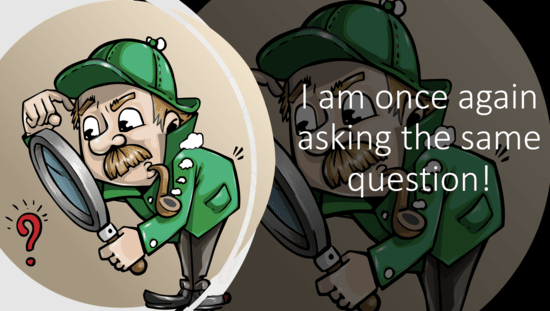


You will process the data first and then pad in a similar way you have done in the previous assignment. Your model will take in the two question embeddings, run them through an LSTM, and then compare the outputs of the two sub networks using cosine similarity. Before taking a deep dive into the model, start by importing the data set.

<a name='1'></a>
## 1 - Importing the Data

<a name='1-1'></a>
### 1.1 - Loading in the Data

You will be using the Quora question answer dataset to build a model that could identify similar questions. This is a useful task because you don't want to have several versions of the same question posted. Several times when teaching I end up responding to similar questions on piazza, or on other community forums. This data set has been labeled for you. Run the cell below to import some of the packages you will be using. 

In [1]:
# Work in Colab in GDrive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/NLP/GitHub/C3_Sequence_Models/04_Siamese_Networks

# Install trax
!pip install -U -q trax

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/NLP/GitHub/C3_Sequence_Models/04_Siamese_Networks


In [2]:
import os
import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
import random as rnd
from trax import shapes

import w4_unittest

# set nltk path
nltk.data.path.append('nltk_data')

# set random seeds
rnd.seed(34)

/usr/local/lib/python3.9/dist-packages/jax/_src/deprecations.py:51: DeprecationWarning: jax.interpreters.xla.DeviceArray is deprecated. Use jax.Array instead.
  warnings.warn(message, DeprecationWarning)


**Notice that for this assignment Trax's numpy is referred to as `fastnp`, while regular numpy is referred to as `np`.**

You will now load in the data set. We have done some preprocessing for you. If you have taken the deeplearning specialization, this is a slightly different training method than the one you have seen there. If you have not, then don't worry about it, we will explain everything. 

In [3]:
data = pd.read_csv("data/questions.csv")
N=len(data)
print('Number of question pairs: ', N)
data.head()

Number of question pairs:  404351


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We first split the data into a train and test set. The test set will be used later to evaluate our model.

In [4]:
N_train = 300000
N_test  = 10*1024
data_train = data[:N_train]
data_test  = data[N_train:N_train+N_test]
print("Train set:", len(data_train), "Test set:", len(data_test))
del(data) # remove to free memory

Train set: 300000 Test set: 10240


As explained in the lectures, we select only the question pairs that are duplicate to train the model. <br>
We build two batches as input for the Siamese network and we assume that question $q1_i$ (question $i$ in the first batch) is a duplicate of $q2_i$ (question $i$ in the second batch), but all other questions in the second batch are not duplicates of $q1_i$.  
The test set uses the original pairs of questions and the status describing if the questions are duplicates.

In [5]:
td_index = (data_train['is_duplicate'] == 1).to_numpy()
td_index = [i for i, x in enumerate(td_index) if x] 
print('number of duplicate questions: ', len(td_index))
print('indexes of first ten duplicate questions:', td_index[:10])

number of duplicate questions:  111486
indexes of first ten duplicate questions: [5, 7, 11, 12, 13, 15, 16, 18, 20, 29]


In [6]:
print(data_train['question1'][5])  #  Example of question duplicates (first one in data)
print(data_train['question2'][5])
print('is_duplicate: ', data_train['is_duplicate'][5])

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
is_duplicate:  1


In [7]:
Q1_train_words = np.array(data_train['question1'][td_index])
Q2_train_words = np.array(data_train['question2'][td_index])

Q1_test_words = np.array(data_test['question1'])
Q2_test_words = np.array(data_test['question2'])
y_test  = np.array(data_test['is_duplicate'])

Above, you have seen that you only took the duplicated questions for training our model. <br>You did so on purpose, because the data generator will produce batches $([q1_1, q1_2, q1_3, ...]$, $[q2_1, q2_2,q2_3, ...])$  where $q1_i$ and $q2_k$ are duplicate if and only if $i = k$.

<br>Let's print to see what your data looks like.

In [8]:
print('TRAINING QUESTIONS:\n')
print('Question 1: ', Q1_train_words[0])
print('Question 2: ', Q2_train_words[0], '\n')
print('Question 1: ', Q1_train_words[5])
print('Question 2: ', Q2_train_words[5], '\n')

print('TESTING QUESTIONS:\n')
print('Question 1: ', Q1_test_words[0])
print('Question 2: ', Q2_test_words[0], '\n')
print('is_duplicate =', y_test[0], '\n')

TRAINING QUESTIONS:

Question 1:  Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Question 2:  I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me? 

Question 1:  What would a Trump presidency mean for current international master’s students on an F1 visa?
Question 2:  How will a Trump presidency affect the students presently in US or planning to study in US? 

TESTING QUESTIONS:

Question 1:  How do I prepare for interviews for cse?
Question 2:  What is the best way to prepare for cse? 

is_duplicate = 0 



You will now encode each word of the selected duplicate pairs with an index. <br> Given a question, you can then just encode it as a list of numbers.  

First you tokenize the questions using `nltk.word_tokenize`. <br>
You need a python default dictionary which later, during inference, assigns the values $0$ to all Out Of Vocabulary (OOV) words.<br>
Then you encode each word of the selected duplicate pairs with an index. Given a question, you can then just encode it as a list of numbers. 

In [9]:
#create arrays
Q1_train = np.empty_like(Q1_train_words)
Q2_train = np.empty_like(Q2_train_words)

Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

In [10]:
# Building the vocabulary with the train set         (this might take a minute)
from collections import defaultdict

vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1

for idx in range(len(Q1_train_words)):
    Q1_train[idx] = nltk.word_tokenize(Q1_train_words[idx])
    Q2_train[idx] = nltk.word_tokenize(Q2_train_words[idx])
    q = Q1_train[idx] + Q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('The length of the vocabulary is: ', len(vocab))

The length of the vocabulary is:  36269


In [11]:
print(vocab['<PAD>'])
print(vocab['Astrology'])
print(vocab['Astronomy'])  #not in vocabulary, returns 0

1
2
0


In [12]:
for idx in range(len(Q1_test_words)): 
    Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])
    Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])

In [13]:
print('Train set has reduced to: ', len(Q1_train) ) 
print('Test set length: ', len(Q1_test) ) 

Train set has reduced to:  111486
Test set length:  10240


<a name='1-2'></a>
### 1.2 - Converting a Question to a Tensor

You will now convert every question to a tensor, or an array of numbers, using your vocabulary built above.

In [14]:
# Converting questions to array of integers
for i in range(len(Q1_train)):
    Q1_train[i] = [vocab[word] for word in Q1_train[i]]
    Q2_train[i] = [vocab[word] for word in Q2_train[i]]

        
for i in range(len(Q1_test)):
    Q1_test[i] = [vocab[word] for word in Q1_test[i]]
    Q2_test[i] = [vocab[word] for word in Q2_test[i]]

In [15]:
print('first question in the train set:\n')
print(Q1_train_words[0], '\n') 
print('encoded version:')
print(Q1_train[0],'\n')

print('first question in the test set:\n')
print(Q1_test_words[0], '\n')
print('encoded version:')
print(Q1_test[0]) 

first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] 

first question in the test set:

How do I prepare for interviews for cse? 

encoded version:
[32, 38, 4, 107, 65, 1015, 65, 11509, 21]


You will now split your train set into a training/validation set so that you can use it to train and evaluate your Siamese model.

In [16]:
# Splitting the data
cut_off = int(len(Q1_train)*.8)
train_Q1, train_Q2 = Q1_train[:cut_off], Q2_train[:cut_off]
val_Q1, val_Q2 = Q1_train[cut_off: ], Q2_train[cut_off:]
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

Number of duplicate questions:  111486
The length of the training set is:   89188
The length of the validation set is:  22298


<a name='1-3'></a>
### 1.3 - Understanding the Iterator 

Most of the time in Natural Language Processing, and AI in general we use batches when training our data sets. If you were to use stochastic gradient descent with one example at a time, it will take you forever to build a model. In this example, we show you how you can build a data generator that takes in $Q1$ and $Q2$ and returns a batch of size `batch_size`  in the following format $([q1_1, q1_2, q1_3, ...]$, $[q2_1, q2_2,q2_3, ...])$. The tuple consists of two arrays and each array has `batch_size` questions. Again, $q1_i$ and $q2_i$ are duplicates, but they are not duplicates with any other elements in the batch. 

<br>

The command ```next(data_generator)```returns the next batch. This iterator returns the data in a format that you could directly use in your model when computing the feed-forward of your algorithm. This iterator returns a pair of arrays of questions. 

<a name='ex-1'></a>
### Exercise 1 - data_generator

**Instructions:**  
Implement the data generator below. Here are some things you will need. 

- While true loop.
- if `index >= len_Q1`, set the `idx` to $0$.
- The generator should return shuffled batches of data. To achieve this without modifying the actual question lists, a list containing the indexes of the questions is created. This list can be shuffled and used to get random batches everytime the index is reset.
- Append elements of $Q1$ and $Q2$ to `input1` and `input2` respectively.
- if `len(input1) == batch_size`, determine `max_len` as the longest question in `input1` and `input2`. Ceil `max_len` to a power of $2$ (for computation purposes) using the following command:  `max_len = 2**int(np.ceil(np.log2(max_len)))`.
- Pad every question by `vocab['<PAD>']` until you get the length `max_len`.
- Use yield to return `input1, input2`. 
- Don't forget to reset `input1, input2`  to empty arrays at the end (data generator resumes from where it last left).

In [17]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: data_generator
def data_generator(Q1, Q2, batch_size, pad=1, shuffle=True):
    """Generator function that yields batches of data

    Args:
        Q1 (list): List of transformed (to tensor) questions.
        Q2 (list): List of transformed (to tensor) questions.
        batch_size (int): Number of elements per batch.
        pad (int, optional): Pad character from the vocab. Defaults to 1.
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Yields:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to your model [q1a, q2a, q3a, ...] i.e. (q1a,q1b) are duplicates
              input2: targets to your model [q1b, q2b,q3b, ...] i.e. (q1a,q2i) i!=a are not duplicates
    """

    input1 = []
    input2 = []
    idx = 0
    len_q = len(Q1)
    question_indexes = [*range(len_q)]
    
    if shuffle:
        rnd.shuffle(question_indexes)
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    while True:
        if idx >= len_q:
            # if idx is greater than or equal to len_q, set idx accordingly 
            # (Hint: look at the instructions above)
            idx = 0
            # shuffle to get random batches if shuffle is set to True
            if shuffle:
                rnd.shuffle(question_indexes) 
        
        # get questions at the `question_indexes[idx]` position in Q1 and Q2
        q1 = Q1[question_indexes[idx]]
        q2 = Q2[question_indexes[idx]]
        
        # increment idx by 1
        idx += 1
        # append q1
        input1.append(q1)
        # append q2
        input2.append(q2)
        if len(input1) == batch_size:
            # determine max_len as the longest question in input1 & input 2
            # Hint: use the `max` function. 
            # take max of input1 & input2 and then max out of the two of them.
            max_len = max(len(max(input1, key=len)), len(max(input2, key=len)))
            # pad to power-of-2 (Hint: look at the instructions above)
            max_len = 2**int(np.ceil(np.log2(max_len)))
            b1 = [] 
            b2 = [] 
            for q1, q2 in zip(input1, input2):
                # add [pad] to q1 until it reaches max_len
                q1 = q1 + [pad] * (max_len-len(q1))
                # add [pad] to q2 until it reaches max_len
                q2 = q2 + [pad] * (max_len-len(q2))
                # append q1
                b1.append(q1)
                # append q2
                b2.append(q2)
            # use b1 and b2
            yield np.array(b1), np.array(b2)
    ### END CODE HERE ###
            # reset the batches
            input1, input2 = [], []  # reset the batches

In [18]:
batch_size = 2
res1, res2 = next(data_generator(train_Q1, train_Q2, batch_size))
print("First questions  : ",'\n', res1, '\n')
print("Second questions : ",'\n', res2)

First questions  :  
 [[  30   87   78  134 2132 1981   28   78  594   21    1    1    1    1
     1    1]
 [  30   55   78 3541 1460   28   56  253   21    1    1    1    1    1
     1    1]] 

Second questions :  
 [[  30  156   78  134 2132 9508   21    1    1    1    1    1    1    1
     1    1]
 [  30  156   78 3541 1460  131   56  253   21    1    1    1    1    1
     1    1]]


**Note**: The following expected output is valid only if you run the above test cell **_once_** (first time). The output will change on each execution.

If you think your implementation is correct and it is not matching the output, make sure to restart the kernel and run all the cells from the top again. 

**Expected Output:**
```CPP
First questions  :  
 [[  30   87   78  134 2132 1981   28   78  594   21    1    1    1    1
     1    1]
 [  30   55   78 3541 1460   28   56  253   21    1    1    1    1    1
     1    1]] 

Second questions :  
 [[  30  156   78  134 2132 9508   21    1    1    1    1    1    1    1
     1    1]
 [  30  156   78 3541 1460  131   56  253   21    1    1    1    1    1
     1    1]]
```
Now that you have your generator, you can just call it and it will return tensors which correspond to your questions in the Quora data set.<br>Now you can go ahead and start building your neural network. 



In [19]:
# Test your function
w4_unittest.test_data_generator(data_generator)

 All tests passed


<a name='2'></a>
## 2 - Defining the Siamese Model

<a name='2-1'></a>
### 2.1 - Understanding Siamese Network 
A Siamese network is a neural network which uses the same weights while working in tandem on two different input vectors to compute comparable output vectors.The Siamese network you are about to implement looks like this:

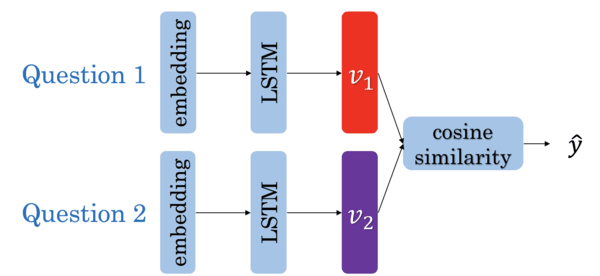

You get the question embedding, run it through an LSTM layer, normalize $v_1$ and $v_2$, and finally use a triplet loss (explained below) to get the corresponding cosine similarity for each pair of questions. As usual, you will start by importing the data set. The triplet loss makes use of a baseline (anchor) input that is compared to a positive (truthy) input and a negative (falsy) input. The distance from the baseline (anchor) input to the positive (truthy) input is minimized, and the distance from the baseline (anchor) input to the negative (falsy) input is maximized. In math equations, you are trying to maximize the following.

$$\mathcal{L}(A, P, N)=\max \left(\|\mathrm{f}(A)-\mathrm{f}(P)\|^{2}-\|\mathrm{f}(A)-\mathrm{f}(N)\|^{2}+\alpha, 0\right)$$

$A$ is the anchor input, for example $q1_1$, $P$ the duplicate input, for example, $q2_1$, and $N$ the negative input (the non duplicate question), for example $q2_2$.<br>
$\alpha$ is a margin; you can think about it as a safety net, or by how much you want to push the duplicates from the non duplicates. 
<br>

<a name='ex-2'></a>
### Exercise 2 - Siamese

**Instructions:** Implement the `Siamese` function below. You should be using all the objects explained below. 

To implement this model, you will be using `trax`. Concretely, you will be using the following functions.


- `tl.Serial`: Combinator that applies layers serially (by function composition) allows you set up the overall structure of the feedforward. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial) / [source code](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/combinators.py#L26)
    - You can pass in the layers as arguments to `Serial`, separated by commas. 
    - For example: `tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.LogSoftmax(...))` 


-  `tl.Embedding`: Maps discrete tokens to vectors. It will have shape (vocabulary length X dimension of output vectors). The dimension of output vectors (also called d_feature) is the number of elements in the word embedding. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding) / [source code](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L113)
    - `tl.Embedding(vocab_size, d_feature)`.
    - `vocab_size` is the number of unique words in the given vocabulary.
    - `d_feature` is the number of elements in the word embedding (some choices for a word embedding size range from 150 to 300, for example).


-  `tl.LSTM` The LSTM layer. It leverages another Trax layer called [`LSTMCell`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.LSTMCell). The number of units should be specified and should match the number of elements in the word embedding. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.LSTM) / [source code](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/rnn.py#L87)
    - `tl.LSTM(n_units)` Builds an LSTM layer of n_units.
    
    
- `tl.Mean`: Computes the mean across a desired axis. Mean uses one tensor axis to form groups of values and replaces each group with the mean value of that group. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Mean) / [source code](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L276)
    - `tl.Mean(axis=1)` mean over columns.


- `tl.Fn` Layer with no weights that applies the function f, which should be specified using a lambda syntax. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn) / [source doce](https://github.com/google/trax/blob/70f5364dcaf6ec11aabbd918e5f5e4b0f5bfb995/trax/layers/base.py#L576)
    - $x$ -> This is used for cosine similarity.
    - `tl.Fn('Normalize', lambda x: normalize(x))` Returns a layer with no weights that applies the function `f`
    
    
- `tl.parallel`: It is a combinator layer (like `Serial`) that applies a list of layers in parallel to its inputs. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Parallel) / [source code](https://github.com/google/trax/blob/37aba571a89a8ad86be76a569d0ec4a46bdd8642/trax/layers/combinators.py#L152)


In [20]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Siamese
def Siamese(vocab_size=41699, d_model=128, mode='train'):
    """Returns a Siamese model.

    Args:
        vocab_size (int, optional): Length of the vocabulary. Defaults to len(vocab).
        d_model (int, optional): Depth of the model. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        trax.layers.combinators.Parallel: A Siamese model. 
    """

    def normalize(x):  # normalizes the vectors to have L2 norm 1
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    q_processor = tl.Serial( # Processor will run on Q1 and Q2. 
        tl.Embedding(vocab_size, d_model), # Embedding layer
        tl.LSTM(d_model, mode=mode), # LSTM layer
        tl.Mean(axis=1), # Mean over columns
        tl.Fn('Normalize', lambda x: normalize(x)), # Apply normalize function
    )  # Returns one vector of shape [batch_size, d_model]. 
    
    ### END CODE HERE ###
    
    # Run on Q1 and Q2 in parallel.
    model = tl.Parallel(q_processor, q_processor)
    return model

Setup the Siamese network model

In [21]:
# check your model
model = Siamese()
print(model)

Parallel_in2_out2[
  Serial[
    Embedding_41699_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_41699_128
    LSTM_128
    Mean
    Normalize
  ]
]


**Expected output:**  

```CPP
Parallel_in2_out2[
  Serial[
    Embedding_41699_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_41699_128
    LSTM_128
    Mean
    Normalize
  ]
]
```

In [22]:
# Test your function
w4_unittest.test_Siamese(Siamese)

 All tests passed


<a name='2-2'></a>
### 2.2 - Hard Negative Mining


You will now implement the `TripletLoss`.<br>
As explained in the lecture, loss is composed of two terms. One term utilizes the mean of all the non duplicates, the second utilizes the *closest negative*. Our loss expression is then:
 
\begin{align}
 \mathcal{Loss_{1}(A,P,N)} &=\max \left( -cos(A,P)  + mean_{neg} +\alpha, 0\right) \\
 \mathcal{Loss_{2}(A,P,N)} &=\max \left( -cos(A,P)  + closest_{neg} +\alpha, 0\right) \\
\mathcal{Loss(A,P,N)} &= mean(Loss_1 + Loss_2) \\
\end{align}


Further, two sets of instructions are provided. The first set provides a brief description of the task. If that set proves insufficient, a more detailed set can be displayed.  

<a name='ex-3'></a>
### Exercise 3 - TripletLossFn

**Instructions (Brief):** Here is a list of things you should do: <br>

- As this will be run inside trax, use `fastnp.xyz` when using any `xyz` numpy function
- Use `fastnp.dot` to calculate the similarity matrix $v_1v_2^T$ of dimension `batch_size` x `batch_size`
- Take the score of the duplicates on the diagonal `fastnp.diagonal`
- Use the `trax` functions `fastnp.eye` and `fastnp.maximum` for the identity matrix and the maximum.

<details>  
<summary>
    <font size="3" color="darkgreen"><b>More Detailed Instructions </b></font>
</summary>
We'll describe the algorithm using a detailed example. Below, V1, V2 are the output of the normalization blocks in our model. Here we will use a batch_size of 4 and a d_model of 3. As explained in lecture, the inputs, Q1, Q2 are arranged so that corresponding inputs are duplicates while non-corresponding entries are not. The outputs will have the same pattern.

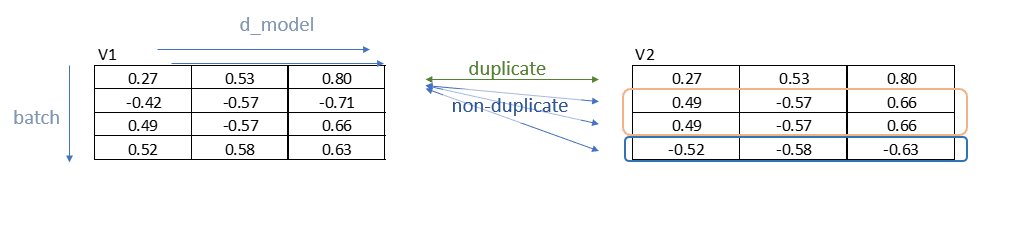

This testcase arranges the outputs, v1,v2, to highlight different scenarios. Here, the first two outputs V1[0], V2[0] match exactly - so the model is generating the same vector for Q1[0] and Q2[0] inputs. The second outputs differ, circled in orange, we set, V2[1] is set to match V2[2], simulating a model which is generating very poor results. V1[3] and V2[3] match exactly again while V1[4] and V2[4] are set to be exactly wrong - 180 degrees from each other, circled in blue. 

The first step is to compute the cosine similarity matrix or `score` in the code. As explained in lecture, this is $$V_1 V_2^T$$ This is generated with `fastnp.dot`.

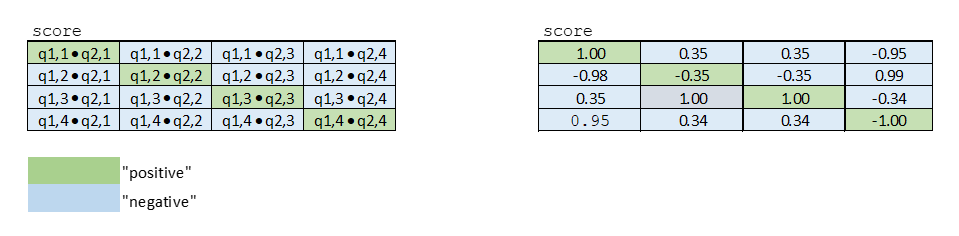

The clever arrangement of inputs creates the data needed for positive *and* negative examples without having to run all pair-wise combinations. Because Q1[n] is a duplicate of only Q2[n], other combinations are explicitly created negative examples or *Hard Negative* examples. The matrix multiplication efficiently produces the cosine similarity of all positive/negative combinations as shown above on the left side of the diagram. 'Positive' are the results of duplicate examples and 'negative' are the results of explicitly created negative examples. The results for our test case are as expected, V1[0]V2[0] match producing '1' while our other 'positive' cases (in green) don't match well, as was arranged. The V2[2] was set to match V1[3] producing a poor match at `score[2,2]` and an undesired 'negative' case of a '1' shown in grey. 

With the similarity matrix (`score`) we can begin to implement the loss equations. First, we can extract $$cos(A,P)$$ by utilizing `fastnp.diagonal`. The goal is to grab all the green entries in the diagram above. This is `positive` in the code.

Next, we will create the *closest_negative*. This is the nonduplicate entry in V2 that is closest (has largest cosine similarity) to an entry in V1. Each row, n, of `score` represents all comparisons of the results of Q1[n] vs Q2[x] within a batch. A specific example in our testcase is row `score[2,:]`. It has the cosine similarity of V1[2] and V2[x]. The *closest_negative*, as was arranged, is V2[2] which has a score of 1. This is the maximum value of the 'negative' entries (blue entries in the diagram).

To implement this, we need to pick the maximum entry on a row of `score`, ignoring the 'positive'/green entries. To avoid selecting the 'positive'/green entries, we can make them larger negative numbers. Multiply `fastnp.eye(batch_size)` with 2.0 and subtract it out of `scores`. The result is `negative_without_positive`. Now we can use `fastnp.max`, row by row (axis=1), to select the maximum which is `closest_negative`.

Next, we'll create *mean_negative*. As the name suggests, this is the mean of all the 'negative'/blue values in `score` on a row by row basis. We can use `fastnp.eye(batch_size)` and a constant, this time to create a mask with zeros on the diagonal. Element-wise multiply this with `score` to get just the 'negative values. This is `negative_zero_on_duplicate` in the code. Compute the mean by using `fastnp.sum` on `negative_zero_on_duplicate` for `axis=1` and divide it by `(batch_size - 1)` . This is `mean_negative`.

Now, we can compute loss using the two equations above and `fastnp.maximum`. This will form `triplet_loss1` and `triplet_loss2`. 

`triple_loss` is the `fastnp.mean` of the sum of the two individual losses.

Once you have this code matching the expected results, you can clip out the section between `### START CODE HERE` and `### END CODE HERE` it out and insert it into TripletLoss below. 

In [23]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: TripletLossFn
def TripletLossFn(v1, v2, margin=0.25):
    """Custom Loss function.

    Args:
        v1 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q1.
        v2 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q2.
        margin (float, optional): Desired margin. Defaults to 0.25.

    Returns:
        jax.interpreters.xla.DeviceArray: Triplet Loss.
    """
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # use fastnp to take the dot product of the two batches (don't forget to transpose the second argument)
    scores = fastnp.dot(v1, v2.T) # pairwise cosine sim    
    # calculate new batch size
    batch_size = len(scores)
    # use fastnp to grab all postive `diagonal` entries in `scores`
    positive = fastnp.diag(scores)  # the positive ones (duplicates)
    # subtract `fastnp.eye(batch_size)` out of 1.0 and do element-wise multiplication with `scores`
    negative_zero_on_duplicate = (1 - fastnp.eye(batch_size)) * scores
    # use `fastnp.sum` on `negative_zero_on_duplicate` for `axis=1` and divide it by `(batch_size - 1)`
    mean_negative = fastnp.sum(negative_zero_on_duplicate, axis=1)/(batch_size - 1)
    # create a composition of two masks: 
    # the first mask to extract the diagonal elements, 
    # the second mask to extract elements in the negative_zero_on_duplicate matrix that are larger than the elements in the diagonal 
    mask_exclude_positives = (positive==1)|(negative_zero_on_duplicate>positive)
    # multiply `mask_exclude_positives` with 2.0 and subtract it out of `negative_zero_on_duplicate`
    negative_without_positive = negative_zero_on_duplicate - mask_exclude_positives * 2.0
    # take the row by row `max` of `negative_without_positive`. 
    # Hint: negative_without_positive.max(axis = [?])  
    closest_negative = negative_without_positive.max(axis=0)
    # compute `fastnp.maximum` among 0.0 and `A`
    # where A = subtract `positive` from `margin` and add `closest_negative`
    # IMPORTANT: DO NOT create an extra variable 'A'
    triplet_loss1 = fastnp.maximum(0, margin - positive + closest_negative)
    # compute `fastnp.maximum` among 0.0 and `B`
    # where B = ubtract `positive` from `margin` and add `mean_negative`
    # IMPORTANT: DO NOT create an extra variable 'B'
    triplet_loss2 = fastnp.maximum(0, margin - positive + mean_negative)
    # add the two losses together and take the `fastnp.sum` of it    
    triplet_loss = fastnp.sum(triplet_loss1 + triplet_loss2)
    ### END CODE HERE ###
    
    return triplet_loss

In [24]:
v1 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
v2 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
print("Triplet Loss:", TripletLossFn(v1,v2))

Triplet Loss: 0.70350766


**Expected Output:**
```CPP
Triplet Loss: ~ 0.70
```   

In [25]:
# Test your function
w4_unittest.test_TripletLossFn(TripletLossFn)

 All tests passed


To make a layer out of a function with no trainable variables, use `tl.Fn`.

In [26]:
from functools import partial
def TripletLoss(margin=0.25):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return tl.Fn('TripletLoss', triplet_loss_fn)

<a name='3'></a>
## 3 - Training

Now you are going to train your model. As usual, you have to define the cost function and the optimizer. You also have to feed in the built model. Before, going into the training, we will use a special data set up. We will define the inputs using the data generator we built above. The lambda function acts as a seed to remember the last batch that was given. Run the cell below to get the question pairs inputs. 

In [27]:
batch_size = 256
train_generator = data_generator(train_Q1, train_Q2, batch_size, vocab['<PAD>'])
val_generator = data_generator(val_Q1, val_Q2, batch_size, vocab['<PAD>'])
print('train_Q1.shape ', train_Q1.shape)
print('val_Q1.shape   ', val_Q1.shape)

train_Q1.shape  (89188,)
val_Q1.shape    (22298,)


<a name='3-1'></a>
### 3.1 - Training the Model

You will now write a function that takes in your model and trains it. To train your model you have to decide how many times you want to iterate over the entire data set; each iteration is defined as an `epoch`. For each epoch, you have to go over all the data, using your training iterator.

<a name='ex-4'></a>
### Exercise 4 - train_model

**Instructions:** Implement the `train_model` below to train the neural network above. Here is a list of things you should do, as already shown in lecture 7: 

- Create `TrainTask` and `EvalTask`
- Create the training loop `trax.supervised.training.Loop`
- Pass in the following depending on the context (train_task or eval_task):
    - `labeled_data=generator`
    - `metrics=[TripletLoss()]`,
    - `loss_layer=TripletLoss()`
    - `optimizer=trax.optimizers.Adam` with learning rate of 0.01
    - `lr_schedule=trax.lr.warmup_and_rsqrt_decay(400, 0.01)`,
    - `output_dir=output_dir`


You will be using your triplet loss function with Adam optimizer. Please read the [trax](https://trax-ml.readthedocs.io/en/latest/trax.optimizers.html?highlight=adam#trax.optimizers.adam.Adam) documentation to get a full understanding. 

This function should return a `training.Loop` object. To read more about this check the [docs](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html?highlight=loop#trax.supervised.training.Loop).

In [28]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: train_model
def train_model(Siamese, TripletLoss
                , train_generator, val_generator, output_dir='model/'):
    """Training the Siamese Model

    Args:
        Siamese (function): Function that returns the Siamese model.
        TripletLoss (function): Function that defines the TripletLoss loss function.
        train_generator (generator, optional): Training generator. Defaults to train_generator.
        val_generator (generator, optional): Validation generator. Defaults to val_generator.
        output_dir (str, optional): Path to save model to. Defaults to 'model/'.

    Returns:
        trax.supervised.training.Loop: Training loop for the model.
    """
    output_dir = os.path.expanduser(output_dir)

    ### START CODE HERE (Replace instances of 'None' with your code) ###

    train_task = training.TrainTask( 
        labeled_data=train_generator,      # Use generator (train)
        loss_layer=TripletLoss(),        # Use triplet loss. Don't forget to instantiate this object
        optimizer=trax.optimizers.Adam(learning_rate=0.01),         # Don't forget to add the learning rate parameter
        lr_schedule=trax.lr.warmup_and_rsqrt_decay(400, 0.01) # Use Trax multifactor schedule function
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator,      # Use generator (val)
        metrics=[TripletLoss()],         # Use triplet loss. Don't forget to instantiate this object
    )
    
    ### END CODE HERE ###

    training_loop = training.Loop(Siamese(),
                                  train_task,
                                  eval_tasks=[eval_task],
                                  output_dir=output_dir)

    return training_loop

In [30]:
train_steps = 5
training_loop = train_model(Siamese, TripletLoss, train_generator, val_generator)
training_loop.run(train_steps)

TypeError: ignored

In [ ]:
# Test your function
w4_unittest.test_train_model(train_model, Siamese, TripletLoss, data_generator)

The model was only trained for 5 steps due to the constraints of this environment. For the rest of the assignment you will be using a pretrained model but now you should understand how the training can be done using Trax.

<a name='4'></a>
## 4 - Evaluation  

<a name='4-1'></a>
### 4.1 - Evaluating your Siamese Network

In this section you will learn how to evaluate a Siamese network. You will first start by loading a pretrained model and then you will use it to predict. 

In [ ]:
model = Siamese()
model.init_from_file(file_name='model.pkl.gz', weights_only=True, input_signature=shapes.signature(next(train_generator)))

<a name='4-2'></a>
### 4.2 - Classify
To determine the accuracy of the model, we will utilize the test set that was configured earlier. While in training we used only positive examples, the test data, Q1_test, Q2_test and y_test, is setup as pairs of questions, some of which are duplicates some are not. 
This routine will run all the test question pairs through the model, compute the cosine simlarity of each pair, threshold it and compare the result to  y_test - the correct response from the data set. The results are accumulated to produce an accuracy.


<a name='ex-5'></a>
### Exercise 5 - classify

**Instructions**  
 - Loop through the incoming data in `batch_size` chunks
 - Use the data generator to load `q1`, `q2` a batch at a time. **Don't forget to set `shuffle=False`!**
 - copy a `batch_size` chunk of `y` into `y_test`
 - compute `v1`, `v2` using the model
 - for each element of the batch
        - compute the cos similarity of each pair of entries, `v1[j]`,`v2[j]`
        - determine if `d` > threshold
        - increment accuracy if that result matches the expected results (`y_test[j]`)
 - compute the final accuracy and return
 
Due to some limitations of this environment, running classify multiple times may result in the kernel failing. If that happens *Restart Kernal & clear output* and then run from the top. During development, consider using a smaller set of data to reduce the number of calls to model(). 

In [ ]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: classify
def classify(test_Q1, test_Q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
    """Function to test the accuracy of the model.

    Args:
        test_Q1 (numpy.ndarray): Array of Q1 questions.
        test_Q2 (numpy.ndarray): Array of Q2 questions.
        y (numpy.ndarray): Array of actual target.
        threshold (float): Desired threshold.
        model (trax.layers.combinators.Parallel): The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        batch_size (int, optional): Size of the batches. Defaults to 64.

    Returns:
        float: Accuracy of the model.
    """    
    
    
    accuracy = 0
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    for i in range(0, len(test_Q1), batch_size):
        # Call the data generator (built in Ex 01) with shuffle= None
        # use batch size chuncks of questions as Q1 & Q2 arguments of the data generator. e.g x[i:i + batch_size]
        # Hint: use `vocab['<PAD>']` for the `pad` argument of the data generator
        q1, q2 = next(data_generator(Q1=test_Q1[i:i + batch_size], Q2=test_Q2[i:i + batch_size], batch_size=batch_size, pad=vocab['<PAD>'], shuffle=False))
        # use batch size chuncks of actual output targets (same syntax as example above)
        y_test = y[i:i + batch_size]
        # Call the model    
        v1, v2 = model((q1, q2))

        for j in range(batch_size):
            # take dot product to compute cos similarity of each pair of entries, v1[j], v2[j]
            # don't forget to transpose the second argument
            d = fastnp.dot(v1[j], v2[j].T)
            # is d greater than the threshold?
            res = d > threshold
            # increment accurancy if y_test is equal `res`
            accuracy += (y_test[j] == res)
    # compute accuracy using accuracy and total length of test questions
    accuracy = accuracy/len(test_Q1)
    ### END CODE HERE ###
    
    return accuracy

In [ ]:
# this takes around 1 minute
accuracy = classify(Q1_test,Q2_test, y_test, 0.7, model, vocab, batch_size = 512) 
print("Accuracy", accuracy)

**Expected Result**  
Accuracy ~0.74

In [ ]:
# Test your function
w4_unittest.test_classify(classify, vocab, data_generator)

<a name='5'></a>
## 5 -Testing with your Own Questions

In this section you will test the model with your own questions. You will write a function `predict` which takes two questions as input and returns $1$ or $0$ depending on whether the question pair is a duplicate or not.   

But first, we build a reverse vocabulary that allows to map encoded questions back to words: 

Write a function `predict`that takes in two questions, the model, and the vocabulary and returns whether the questions are duplicates ($1$) or not duplicates ($0$) given a similarity threshold. 

<a name='ex-6'></a>
### Exercise 6 - predict


**Instructions:** 
- Tokenize your question using `nltk.word_tokenize` 
- Create Q1,Q2 by encoding your questions as a list of numbers using vocab
- pad Q1,Q2 with next(data_generator([Q1], [Q2],1,vocab['<PAD>']))
- use model() to create v1, v2
- compute the cosine similarity (dot product) of v1, v2
- compute res by comparing d to the threshold


In [ ]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: predict
def predict(question1, question2, threshold, model, vocab, data_generator=data_generator, verbose=False):
    """Function for predicting if two questions are duplicates.

    Args:
        question1 (str): First question.
        question2 (str): Second question.
        threshold (float): Desired threshold.
        model (trax.layers.combinators.Parallel): The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        verbose (bool, optional): If the results should be printed out. Defaults to False.

    Returns:
        bool: True if the questions are duplicates, False otherwise.
    """
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # use `nltk` word tokenize function to tokenize
    q1 = nltk.word_tokenize(question1)  # tokenize
    q2 = nltk.word_tokenize(question2)  # tokenize
    Q1, Q2 = [], []
    for word in q1:  # encode q1
        # append the 'word' index in `vocab`
        Q1.append(vocab[word])
    for word in q2:  # encode q2
        # append the 'word' index in `vocab`
        Q2.append(vocab[word])
        
    # Call the data generator (built in Ex 01) using next()
    # pass [Q1] & [Q2] as Q1 & Q2 arguments of the data generator. Set batch size as 1
    # Hint: use `vocab['<PAD>']` for the `pad` argument of the data generator
    Q1, Q2 = next(data_generator([Q1], [Q2], 1))
    # Call the model
    v1, v2 = model((Q1, Q2))
    # take dot product to compute cos similarity of each pair of entries, v1, v2
    # don't forget to transpose the second argument
    d = fastnp.dot(v1, v2.T)
    # is d greater than the threshold?
    res = d > threshold
    
    ### END CODE HERE ###
    
    if(verbose):
        print("Q1  = ", Q1, "\nQ2  = ", Q2)
        print("d   = ", d)
        print("res = ", res)

    return res

In [ ]:
# Feel free to try with your own questions
question1 = "When will I see you?"
question2 = "When can I see you again?"
# 1/True means it is duplicated, 0/False otherwise
predict(question1 , question2, 0.7, model, vocab, verbose = True)

##### Expected Output
If input is:
```CPP
question1 = "When will I see you?"
question2 = "When can I see you again?"
```

Output is (d may vary a bit):
```CPP
Q1  =  [[585  76   4  46  53  21   1   1]] 
Q2  =  [[ 585   33    4   46   53 7280   21    1]]
d   =  0.8585515
res =  True
True
```

In [ ]:
# Feel free to try with your own questions
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
# 1/True means it is duplicated, 0/False otherwise
predict(question1 , question2, 0.7, model, vocab, verbose=True)

##### Expected output

If input is:
```CPP
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
```

Output  (d may vary a bit):

```CPP
Q1  =  [[  443  1145  3159  1169    78 29017    21     1]] 
Q2  =  [[  443  1145    60 15302    28    78  7431    21]]
d   =  0.53644466
res =  False
False
```

You can see that the Siamese network is capable of catching complicated structures. Concretely it can identify question duplicates although the questions do not have many words in common. 
 

In [ ]:
# Test your function
w4_unittest.test_predict(predict, vocab, data_generator)

<a name='6'></a>
###  <span style="color:blue"> On Siamese Networks </span>

Siamese networks are important and useful. Many times there are several questions that are already asked in quora, or other platforms and you can use Siamese networks to avoid question duplicates. 

Congratulations, you have now built a powerful system that can recognize question duplicates. In the next course we will use transformers for machine translation, summarization, question answering, and chatbots. 
